In [1]:
# !pip install tensorflow

In [1]:
# Bilbliotecas necessarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
from keras.models import load_model 

2023-04-16 17:02:56.594670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 17:02:56.644775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 17:02:56.645967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 17:02:57.498208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Importacao dp modelo treinado do Keras

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the trained model
model = load_model("keras_model.h5", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()



2023-04-16 17:02:58.601680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 17:02:58.602606: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Listas das imagens

lista_nok_borda = os.listdir("./assets/NOK_borda/")
lista_nok_superficie = os.listdir("./assets/NOK_superficie/")
lista_nok_tamanho_forma = os.listdir("./assets/NOK_tamanho_forma/")
lista_ok = os.listdir("./assets/OK/")

lista_nok_borda = [f"./assets/NOK_borda/{filename}" for filename in lista_nok_borda]
lista_nok_superficie = [f"./assets/NOK_superficie/{filename}" for filename in lista_nok_superficie]
lista_nok_tamanho_forma = [f"./assets/NOK_tamanho_forma/{filename}" for filename in lista_nok_tamanho_forma]
lista_ok = [f"./assets/OK/{filename}" for filename in lista_ok]

lista_total = []
lista_total.extend(lista_nok_borda)
lista_total.extend(lista_nok_superficie)
lista_total.extend(lista_nok_tamanho_forma)
lista_total.extend(lista_ok)

lista_total

['./assets/NOK_borda/Fig_NOK_09.jpg',
 './assets/NOK_borda/Fig_NOK_11.jpg',
 './assets/NOK_borda/Fig_NOK_13.jpg',
 './assets/NOK_borda/Fig_NOK_14.jpg',
 './assets/NOK_borda/Fig_NOK_12.jpg',
 './assets/NOK_borda/Fig_NOK_08.jpg',
 './assets/NOK_borda/Fig_NOK_10.jpg',
 './assets/NOK_borda/Fig_NOK_06.jpg',
 './assets/NOK_borda/Fig_NOK_15.jpg',
 './assets/NOK_borda/Fig_NOK_07.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_08.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_04.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_06.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_03.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_01.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_05.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_02.jpg',
 './assets/NOK_superficie/Fig_NOK_Superf_07.jpg',
 './assets/NOK_tamanho_forma/Fig_NOK_05.jpg',
 './assets/NOK_tamanho_forma/Fig_NOK_04.jpg',
 './assets/NOK_tamanho_forma/Fig_NOK_02.jpg',
 './assets/NOK_tamanho_forma/Fig_NOK_03.jpg',
 './assets/NOK_tamanho_forma/Fig_NOK

## Borda

In [4]:
def fillHoles(img_thr):

    """
    Prenche furos internos em blobs, que deve ser branco (intensidade=255)

    Keyword arguments:
    img_thr -- nparray uint8 da imagem de entrada (imagem binarizada)

    Returns:
    img_out -- npaarray (uint8) da imagem apos preenchimento dos furos

    """

    img_floodfill = img_thr.copy()
    h, w = img_thr.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(img_floodfill, mask, (0,0), 255)
    img_floodfill_inv = cv2.bitwise_not(img_floodfill)
    img_out = img_thr | img_floodfill_inv

    return img_out

In [5]:
def calcula_diametro(comprimento_px, largura_real_cm, comprimento_obj):

    # mede o comprimento da imagem em pixels
    comprimento_px = comprimento_px

    # calcula a relação de pixels por centímetro (ppc)
    ppc = comprimento_px / largura_real_cm

    # mede o comprimento de um objeto na imagem em pixels
    comprimento_objeto_px = comprimento_obj

    # converte o comprimento em pixels para centímetros
    comprimento_objeto_cm = comprimento_objeto_px / ppc

    raio = comprimento_objeto_cm/10
   
    nominal = 50
    tolerancia = 1

    return raio


In [6]:
def calcula_relacao_eixo_a_e_b(ellipse):
    a, b = ellipse[1][0]/2, ellipse[1][1]/2
    teste_a_b = a/b
    
    return teste_a_b

In [7]:
def fun_diametro(img):
    contagem_pixels = []

    # Percorre cada linha da imagem
    for y in range(img.shape[0]):
        # Conta o número de pixels 255 na linha atual
        contagem = cv2.countNonZero(img[y])
        # Adiciona o número de pixels contados à lista
        contagem_pixels.append(contagem)
    # Encontra a linha com o maior número de pixels 255
    linha_mais_pixels = max(contagem_pixels)
    return linha_mais_pixels


In [10]:
df = pd.DataFrame(
    columns=["FILENAME", "TESTE - BORDA", "TESTE - SUPERFICIE", "DIAMETRO", "STATUS - DIAMETRO", "A/B", "STATUS - A/B"]
)
for path in lista_total:
    TESTE_BORDA = "-"
    TESTE_SUPERFICIE = "-"
    DIAMETRO = "-"
    AB = "-"
    STATUS_DIAMETRO = "-"
    STATUS_AB = "-"
    FILENAME = path
    
    fig_borda = cv2.imread(path)

    # Separa os canais HSV
    hsv = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2HSV)

    h,s,v = cv2.split(hsv)

    hsv_min = np.array([120, 0, 0])
    hsv_max = np.array([255, 150, 95])

    mask = cv2.inRange(fig_borda, hsv_min, hsv_max)

    result = cv2.bitwise_and(fig_borda, fig_borda, mask=~mask)

    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    _, fig_gray = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    blur = cv2.medianBlur(fig_gray, 5)
    
#     kp = detector.detect(blur)

    contours, _ = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = max(contours, key = cv2.contourArea)
    ellipse = cv2.fitEllipse(cnt)
    
    _, radius = cv2.minEnclosingCircle(cnt)

    area_contour = cv2.contourArea(cnt)
    area_ellipse = np.pi * ellipse[1][0] * ellipse[1][1] / 4.0
    diff = area_ellipse - area_contour
        
    if(diff > 20):
        TESTE_BORDA = "Reprovado"
        data = {
           "FILENAME": [FILENAME],
           "TESTE - BORDA": [TESTE_BORDA],
           "TESTE - SUPERFICIE": [TESTE_SUPERFICIE],
           "DIAMETRO": [DIAMETRO],
           "STATUS - DIAMETRO": [STATUS_DIAMETRO],
           "A/B": [AB],
           "STATUS - A/B": [STATUS_AB]
        }
        data = pd.DataFrame(data)
        df = pd.concat([df, data], ignore_index=True)
        continue
    else:
        TESTE_BORDA = "Aprovado"
        



    # teste de superficie

    # Resize the raw image into (224-height,224-width) pixels
    image = cv2.resize(fig_borda, (224, 224), interpolation=cv2.INTER_AREA)

    # Make the image a numpy array and reshape it to the models input shape.
    image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

    # Normalize the image array
    image = (image / 127.5) - 1

    # Predicts the model
    prediction = model.predict(image)
    index = np.argmax(prediction)
    confidence_score = prediction[0][index]

    if(index == 1):
        TESTE_SUPERFICIE = "Reprovado"
        data = {
           "FILENAME": [FILENAME],
           "TESTE - BORDA": [TESTE_BORDA],
           "TESTE - SUPERFICIE": [TESTE_SUPERFICIE],
           "DIAMETRO": [DIAMETRO],
           "STATUS - DIAMETRO": [STATUS_DIAMETRO],
           "A/B": [AB],
           "STATUS - A/B": [STATUS_AB]
        }
        data = pd.DataFrame(data)
        df = pd.concat([df, data], ignore_index=True)
        continue
    else:
        TESTE_SUPERFICIE = "Aprovado"
        
    




        

    linha_mais_pixels = fun_diametro(blur)
    diametro = calcula_diametro(508, 650, linha_mais_pixels)

    if(diametro > 49.5 and diametro < 50.5):
        STATUS_DIAMETRO = "Aprovado"
        DIAMETRO = diametro
    else:
        STATUS_DIAMETRO = "Reprovado"
        DIAMETRO = diametro

    ab = calcula_relacao_eixo_a_e_b(ellipse)
    if(ab > 0.95 and ab < 1.05):
        AB = ab
        STATUS_AB = "Aprovado"
    else:
        AB = ab
        STATUS_AB = "Reprovado"
        
    data = {
       "FILENAME": [FILENAME],
       "TESTE - BORDA": [TESTE_BORDA],
       "TESTE - SUPERFICIE": [TESTE_SUPERFICIE],
       "DIAMETRO": [DIAMETRO],
       "STATUS - DIAMETRO": [STATUS_DIAMETRO],
       "A/B": [AB],
       "STATUS - A/B": [STATUS_AB],
    }
    data = pd.DataFrame(data)
    df = pd.concat([df, data], ignore_index=True)
df

# Saves the Data frame on a CSV file
df.to_csv('./image_result.csv') 


1/1 [==============================] - 0s 32ms/step


# Teste de borda por desvio padrao dos diametros

### Teste para um dataset the NOK_borda e OK

In [32]:
lista_teste = lista_nok_borda+lista_ok
print(lista_teste)

['./assets/NOK_borda/Fig_NOK_09.jpg', './assets/NOK_borda/Fig_NOK_11.jpg', './assets/NOK_borda/Fig_NOK_13.jpg', './assets/NOK_borda/Fig_NOK_14.jpg', './assets/NOK_borda/Fig_NOK_12.jpg', './assets/NOK_borda/Fig_NOK_08.jpg', './assets/NOK_borda/Fig_NOK_10.jpg', './assets/NOK_borda/Fig_NOK_06.jpg', './assets/NOK_borda/Fig_NOK_15.jpg', './assets/NOK_borda/Fig_NOK_07.jpg', './assets/OK/Fig_OK_09.jpg', './assets/OK/Fig_OK_08.jpg', './assets/OK/Fig_OK_04.jpg', './assets/OK/Fig_OK_10.jpg', './assets/OK/Fig_OK_15.jpg', './assets/OK/Fig_OK_06.jpg', './assets/OK/Fig_OK_05.jpg', './assets/OK/Fig_OK_07.jpg', './assets/OK/Fig_OK_11.jpg', './assets/OK/Fig_OK_01.jpg', './assets/OK/Fig_OK_02.jpg', './assets/OK/Fig_OK_14.jpg', './assets/OK/Fig_OK_03.jpg', './assets/OK/Fig_OK_12.jpg', './assets/OK/Fig_OK_13.jpg']


In [64]:
for path in lista_teste:

    # Load image

    fig_borda = cv2.imread(path)

    # Separa os canais HSV
    hsv = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2HSV)

    h,s,v = cv2.split(hsv)

    hsv_min = np.array([120, 0, 0])
    hsv_max = np.array([255, 150, 95])

    mask = cv2.inRange(fig_borda, hsv_min, hsv_max)

    result = cv2.bitwise_and(fig_borda, fig_borda, mask=~mask)

    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    _, fig_gray = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    blur = cv2.medianBlur(fig_gray, 5)


    # plt.imshow(blur, cmap="gray")
    # plt.show()





    img = blur
    # Get image dimensions
    height, width = img.shape[:2]


    diametros = []
    diametros.append(0)
    for angle in range(179):
        # Calculate rotation matrix
        M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
        # Apply rotation to image
        rotated_img = cv2.warpAffine(img, M, (width, height))
        diametro = fun_diametro(rotated_img)
        diametros.append(diametro)


    value = np.std(diametros[1::])
    if value > 1.67:
        print("Reprovado: ", path, "  ", value)
    else:
        print("Aprovado", path, "  ", value)


Reprovado:  ./assets/NOK_borda/Fig_NOK_09.jpg    4.180645174651837
Reprovado:  ./assets/NOK_borda/Fig_NOK_11.jpg    20.37040202381334
Reprovado:  ./assets/NOK_borda/Fig_NOK_13.jpg    7.386636881513652
Reprovado:  ./assets/NOK_borda/Fig_NOK_14.jpg    1.7958613024941399
Reprovado:  ./assets/NOK_borda/Fig_NOK_12.jpg    2.5248677363840795
Reprovado:  ./assets/NOK_borda/Fig_NOK_08.jpg    10.58856277999465
Reprovado:  ./assets/NOK_borda/Fig_NOK_10.jpg    1.848934145186738
Reprovado:  ./assets/NOK_borda/Fig_NOK_06.jpg    1.6786570760512511
Reprovado:  ./assets/NOK_borda/Fig_NOK_15.jpg    1.9257138017539686
Reprovado:  ./assets/NOK_borda/Fig_NOK_07.jpg    7.7449512686565924
Aprovado ./assets/OK/Fig_OK_09.jpg    1.4301239518479725
Aprovado ./assets/OK/Fig_OK_08.jpg    1.215234691716044
Aprovado ./assets/OK/Fig_OK_04.jpg    1.6635291879791136
Reprovado:  ./assets/OK/Fig_OK_10.jpg    1.902937958068371
Aprovado ./assets/OK/Fig_OK_15.jpg    1.3537547468925997
Aprovado ./assets/OK/Fig_OK_06.jpg    0

### Teste por imagem (Individual)

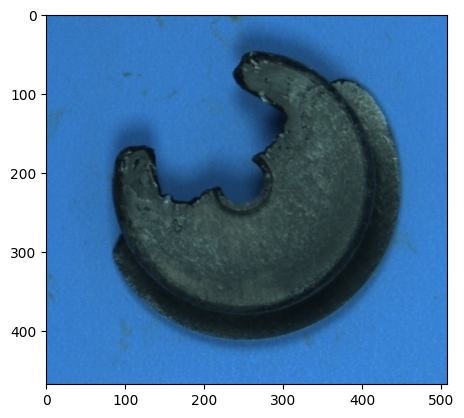

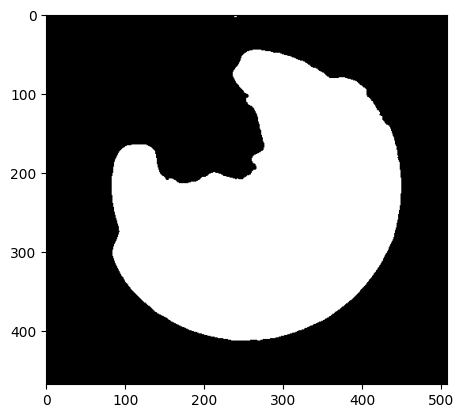

In [8]:
    # Load image

fig_borda = cv2.imread("./assets/NOK_borda/Fig_NOK_11.jpg")
#fig_borda = cv2.imread("./assets/OK/Fig_OK_10.jpg")

# Separa os canais HSV
hsv = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2HSV)

h,s,v = cv2.split(hsv)

hsv_min = np.array([120, 0, 0])
hsv_max = np.array([255, 150, 95])

mask = cv2.inRange(fig_borda, hsv_min, hsv_max)

result = cv2.bitwise_and(fig_borda, fig_borda, mask=~mask)

gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

_, fig_gray = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

blur = cv2.medianBlur(fig_gray, 5)

fig_borda = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2RGB)

plt.imshow(fig_borda, cmap="gray")
plt.show()

plt.imshow(blur, cmap="gray")
plt.show()


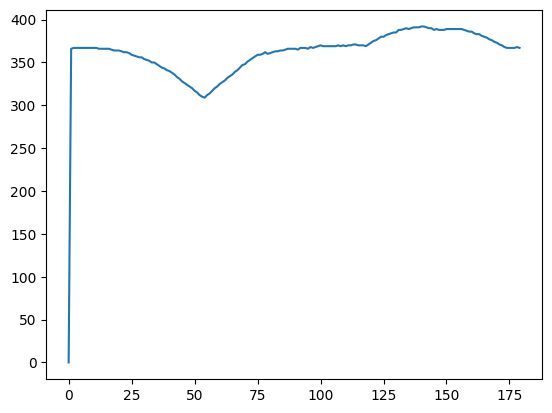

In [9]:


img = blur
# Get image dimensions
height, width = img.shape[:2]


diametros = []
diametros.append(0)
for angle in range(179):
    # Calculate rotation matrix
    M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    # Apply rotation to image
    rotated_img = cv2.warpAffine(img, M, (width, height))
    diametro = fun_diametro(rotated_img)
    diametros.append(diametro)
    

plt.plot(np.arange(0,180, 1), diametros)

In [10]:
np.std(diametros[1::])

20.37040202381334

25.433370935635303


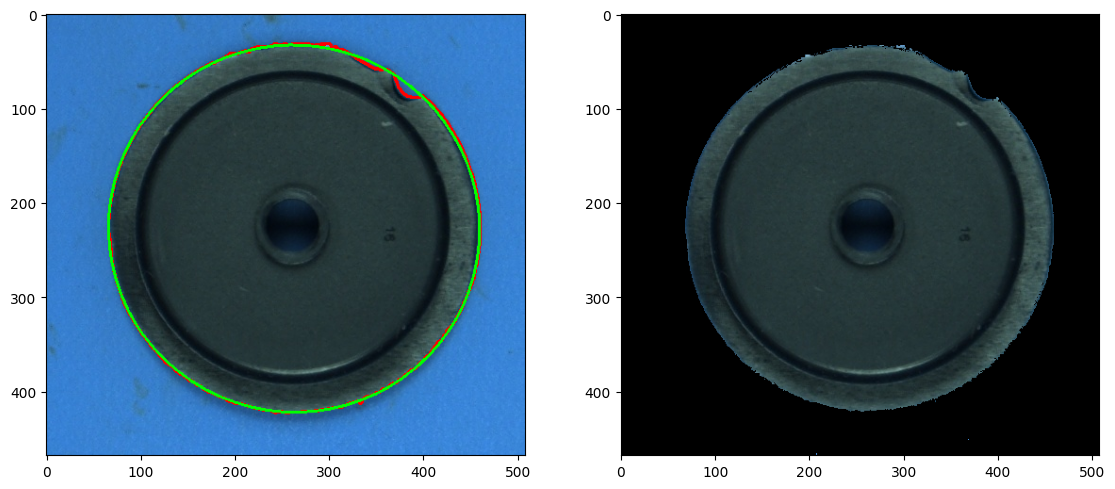

In [68]:
fig_borda = cv2.imread("./assets/NOK_borda/Fig_NOK_06.jpg")

# Separa os canais HSV
hsv = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2HSV)

h,s,v = cv2.split(hsv)

# hsv_min = np.array([120, 0, 0])
# hsv_max = np.array([255, 150, 95])

hsv_min = np.array([110, 0, 0])
hsv_max = np.array([255, 150, 72])

mask = cv2.inRange(fig_borda, hsv_min, hsv_max)

result = cv2.bitwise_and(fig_borda, fig_borda, mask=~mask)

gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

_, fig_gray = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

blur = cv2.GaussianBlur(fig_gray, (5,5), 0.7, 0.7)

contours, _ = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnt = max(contours, key = cv2.contourArea)
ellipse = cv2.fitEllipse(cnt)

area_contour = cv2.contourArea(cnt)
area_ellipse = np.pi * ellipse[1][0] * ellipse[1][1] / 4.0
diff = area_ellipse - area_contour
# print(area_contour, area_ellipse,diff, path)
(x,y), radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
area_contour = cv2.contourArea(cnt)
area_ellipse = np.pi * ellipse[1][0] * ellipse[1][1] / 4.0
diff = area_ellipse - area_contour

raio = calcula_diametro(comprimento_px=fig_borda.shape[1], largura_real_cm=650, comprimento_obj=radius)
print(raio)

cv2.drawContours(fig_borda,[cnt], -1, (0,0,255), 2)
# cv2.circle(fig_borda, center, int(radius), (0, 255, 0), 2)
cv2.ellipse(fig_borda, ellipse, (0, 255, 0), 2)

plt.figure(figsize=(21,21))
plt.subplot(1,3,1)
plt.imshow(fig_borda[:,:,::-1])
plt.subplot(1,3,2)
plt.imshow(result[:,:,::-1])

In [ ]:
for path in lista_nok_borda:
    fig_borda = cv2.imread(path)
    
    # dividir a imagem em seus canais de cores
    b, g, r = cv2.split(fig_borda)

    # criar uma matriz nula para os outros canais
    zeros = np.zeros_like(b)

    # mesclar os canais para obter somente o canal azul
    blue_img = cv2.merge((zeros, g, zeros))

    x = cv2.cvtColor(blue_img, cv2.COLOR_BGR2GRAY)

    _, fig_th = cv2.threshold(x, 41, 255, cv2.THRESH_BINARY_INV)
    
    fig_th = cv2.medianBlur(fig_th, 5)

    contours, _ = cv2.findContours(fig_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = max(contours, key = cv2.contourArea)
    area = cv2.contourArea(cnt)

    # Calcula o diâmetro do objeto
    _, radius = cv2.minEnclosingCircle(cnt)
    diameter = 2 * radius

    # Calcula a área de um círculo com o mesmo diâmetro do objeto
    circle_area = np.pi * (diameter/2)**2

    # Calcula a relação entre a área do objeto e a área do círculo
    circularity = area / circle_area

    print(circularity)

    cv2.drawContours(fig_borda, [cnt], -1, (0,255, 0), 3)

    plt.figure(figsize=(15, 21))
    plt.subplot(1,2,1)
    plt.imshow(fig_th, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(fig_borda[:,:,::-1])
    plt.show()

In [ ]:
for path in lista_ok:
    fig_borda = cv2.imread(path)
    
    # dividir a imagem em seus canais de cores
    b, g, r = cv2.split(fig_borda)

    # criar uma matriz nula para os outros canais
    zeros = np.zeros_like(b)

    # mesclar os canais para obter somente o canal azul
    blue_img = cv2.merge((b, zeros, zeros))

    x = cv2.cvtColor(blue_img, cv2.COLOR_BGR2GRAY)

    _, fig_th = cv2.threshold(x, 13, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(fig_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = max(contours, key = cv2.contourArea)
    area = cv2.contourArea(cnt)

    # Calcula o diâmetro do objeto
    _, radius = cv2.minEnclosingCircle(cnt)
    diameter = 2 * radius

    # Calcula a área de um círculo com o mesmo diâmetro do objeto
    circle_area = np.pi * (diameter/2)**2

    # Calcula a relação entre a área do objeto e a área do círculo
    circularity = area / circle_area

    print(circularity)

    cv2.drawContours(fig_borda, [cnt], -1, (0,255, 0), 3)

    plt.figure(figsize=(15, 21))
    plt.subplot(1,2,1)
    plt.imshow(fig_th, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(fig_borda[:,:,::-1])
    plt.show()

In [ ]:
for path in lista_nok_superficie:
    fig_borda = cv2.imread(path)
    
    hsv = cv2.cvtColor(fig_borda, cv2.COLOR_BGR2HSV)
    # Define o intervalo de cores a ser removido (verde)
    lower_blue = np.array([0, 0, 50])
    upper_blue = np.array([100, 100, 255])

    # Cria uma máscara com os pixels na faixa de cores definida
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    result = fig_borda.copy()
    result[mask > 0] = [0, 0, 0] 

    x = cv2.cvtColor(result, cv2.COLOR_HSV2BGR)
    x = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    _, fig_th = cv2.threshold(x, 50, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(fig_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = max(contours, key = cv2.contourArea)
    area = cv2.contourArea(cnt)

    # Calcula o diâmetro do objeto
    _, radius = cv2.minEnclosingCircle(cnt)
    diameter = 2 * radius

    # Calcula a área de um círculo com o mesmo diâmetro do objeto
    circle_area = np.pi * (diameter/2)**2

    # Calcula a relação entre a área do objeto e a área do círculo
    circularity = area / circle_area

    print(circularity)

#     cv2.drawContours(fig_borda, [cnt], -1, (0,255, 0), 3)

#     plt.figure(figsize=(15, 21))
#     plt.subplot(1,2,1)
#     plt.imshow(fig_th, cmap="gray")
#     plt.subplot(1,2,2)
#     plt.imshow(fig_borda[:,:,::-1])
#     plt.show()